In [257]:
import tensorflow.compat.v1 as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, concatenate, Input, Embedding
from tensorflow.keras.layers import Reshape, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import numpy as np
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [258]:
def one_hot(df, cols):
  """Returns one-hot encoding of DataFrame df including columns in cols."""
  for col in cols:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(col, axis=1)
  return df


## Load data

In [259]:
data = pd.read_csv('data/adult.data')
data.columns = ['age', 'workclass', 'weight', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

elvis = [25, 'Private', 27821, 'Bachelors', 17, 'Married-civ-spouse', 'Other-service', 'Husband', 'Asian-Pac-Islander', 'Male', 1000, 2000, 40, 'China', '<=50K']

#Shuffle
data = data.sample(frac=1)

# Add our test data
data = data.append(pd.Series(elvis, index=data.columns ), ignore_index=True)

elvis_df = data.iloc[-1]



In [260]:
# Remove occupation from df as it's our label, then create a mapping of labels
actions = data['occupation'].astype('category').cat.codes #.to_numpy()
action_space = data['occupation'].astype('category').cat.categories
actions_mapping = dict(enumerate(data['occupation'].astype('category').cat.categories))

df = data.drop(['occupation'], axis = 1)
df = one_hot(df, ['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country', 'income'])

# Setup rewards and drop income column
rewards = df['income_ >50K']
df = df.drop(['income_ >50K', 'income_ <=50K'], axis = 1)

In [261]:
## scikit-learn scaler object to scale the states
scaler = StandardScaler()
scaler.fit(df)
df = scaler.transform(df)

## Trian test split

In [262]:
n_data, state_size = df.shape
n_train = n_data // 3 * 2
train_data = df[:n_train]
test_data = df[n_train:]

print("total data size: {}".format(df.shape))
print("training data size: {}".format(train_data.shape))
print("test data size: {}".format(test_data.shape))

# test_df = pd.concat([actions[n_train:], rewards[n_train:]], axis=1).reset_index()
# test_df = test_df.drop(['index'], axis = 1)
# test_df.columns = ['action', 'income']
# test_df.query('income > 0')

total data size: (32561, 101)
training data size: (21706, 101)
test data size: (10855, 101)


### Defining our neural network used by the agent

In [263]:
def build_model(state_size, action_size):
    # shared layer
    model = Sequential([
        Input(shape=(state_size,)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(action_size, activation='relu')])
    
    # compiling
    model.compile(loss='mse', optimizer='adam')
    
    # returning the model
    return model


## Define agent

Here the contextual bandit problem is a simplified version of a full RL problem, where the beginning state is the previous state of a terminal state. Therefore we can simplify the following Bellman's equation
![alt text](https://miro.medium.com/max/5032/1*CiDCpUjj_3mGm3vdGrxu4g.png)

into just 
```
V(s)=max(R(s,a))
```
as terminal states have value of 0



In [264]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = build_model(state_size, action_size)
        self.loss = []
    
    def act(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def learn(self, states, actions, rewards):
        # Calculate the tentative target: Q(s',a)
        target = rewards

        # With the Keras API, the target (usually) must have the same
        # shape as the predictions.
        # However, we only need to update the network for the actions
        # which were actually taken.
        # We can accomplish this by setting the target to be equal to
        # the prediction for all values.
        # Then, only change the targets for the actions taken.
        # Q(s,a)
        target_full = self.model.predict(states)
        target_full[np.arange(states.shape[0]), actions] = target

        # Run one training step
        res = self.model.train_on_batch(states, target_full)
        self.loss.append(res)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
        
class RandomAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
    
    def act(self, state):
        return np.random.choice(self.action_size)
    

Training on sample size of:
21706
training 50/339
training 100/339
training 150/339
training 200/339
training 250/339
training 300/339


Text(0, 0.5, 'Loss (mse)')

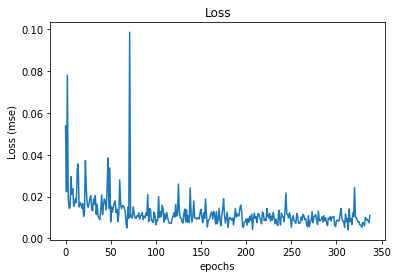

In [265]:
dqn_agent = DQNAgent(state_size, action_space.shape[0])

print("Training on sample size of:")
print(train_data.shape[0])

BATCH_SIZE = 64
for i in range(1, n_train//BATCH_SIZE):
    if(i%50 == 0):
        print("training {}/{}".format(i, n_train // BATCH_SIZE))
        
    dqn_agent.learn(train_data[(i - 1) * BATCH_SIZE : BATCH_SIZE * i], 
                actions[(i - 1) * BATCH_SIZE : BATCH_SIZE * i], 
                rewards[(i - 1) * BATCH_SIZE : BATCH_SIZE * i])

    
plt.plot(dqn_agent.loss)
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss (mse)")

In [266]:
print(elvis_df)

age                               25
workclass                    Private
weight                         27821
education                  Bachelors
education-num                     17
marital-status    Married-civ-spouse
occupation             Other-service
relationship                 Husband
race              Asian-Pac-Islander
sex                             Male
capital-gain                    1000
capital-loss                    2000
hours-per-week                    40
native-country                 China
income                         <=50K
Name: 32560, dtype: object


In [267]:
act_values = agent.model.predict(df[-2:-1])
print("This is the agent's recommendation:")
print(action_space[np.argmax(act_values)])

This is the agent's recommendation:
 Protective-serv


### Compare our agent with a RandomAgent

predicting 94/1000
predicting 194/1000
predicting 294/1000
predicting 394/1000
predicting 494/1000
predicting 594/1000
predicting 694/1000
predicting 794/1000
predicting 894/1000
predicting 994/1000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BA3F14E488>,
      dtype=object)

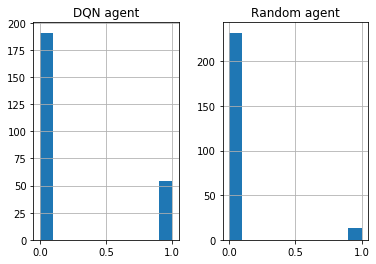

In [268]:
random_agent = RandomAgent(state_size, action_space.shape[0])

def bool_to_int(b):
    if b:
        return 1
    return 0

## Compare with baseline algorithm
retro_actions = []
pred = pd.DataFrame()
pred = pd.concat([pred,pd.DataFrame([pd.Series([0,0])])])

for i in range(n_train, n_train + 1000):
    if i % 100 == 0:
        print("predicting {}/{}".format(i-n_train, 1000))
    if rewards[i] == 1:
        pred = pd.concat([pred,pd.DataFrame([pd.Series([bool_to_int(dqn_agent.act(df[i:i+1]) == actions[i]),
                                                       random_agent.act(df[i:i+1]) == actions[i]])])])
pred.columns = ['DQN agent', 'Random agent']
pred.hist()

504
133
